# Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import os
from tqdm import tqdm
import sklearn
import seaborn as sns
import plotly.express as px


import geopandas as gpd
from shapely.geometry import Point, Polygon

In [2]:
filename = '../input/birdclef-2021/train_short_audio/annhum/XC151103.ogg'

In [3]:
SR = 25000

# Visualize audio

Sample Rate:  25000


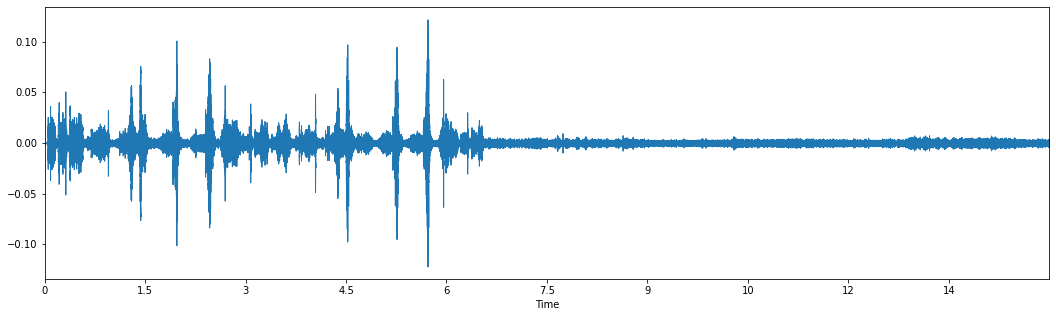

In [4]:
plt.figure(figsize=(18, 5))

# by default librosa.load returns a sample rate of 22050
# librosa converts input to mono, hence always 

data, sample_rate = librosa.load(filename, sr=SR, offset=None, duration=15)

# Plot the amplitude envelope of a waveform.
librosa.display.waveplot(data, sr=sample_rate)
print("Sample Rate: ", sample_rate)
ipd.Audio(filename)

## Spectrogram
A spectrogram is a visual way of representing the signmal strength, or **"loudness"** of a signal over time at various frequencies present in a particular waveform.

For a detailed overview of **specshow** function, see [Using display.specshow](https://librosa.org/doc/main/auto_examples/plot_display.html#sphx-glr-auto-examples-plot-display-py)

# Short-time Fourier transform (STFT).

The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.

This function returns a complex-valued matrix D such that

* np.abs(D[f, t]) is the magnitude of frequency bin **f** at frame **t**, and

* np.angle(D[f, t]) is the phase of frequency bin **f** at frame **t**.

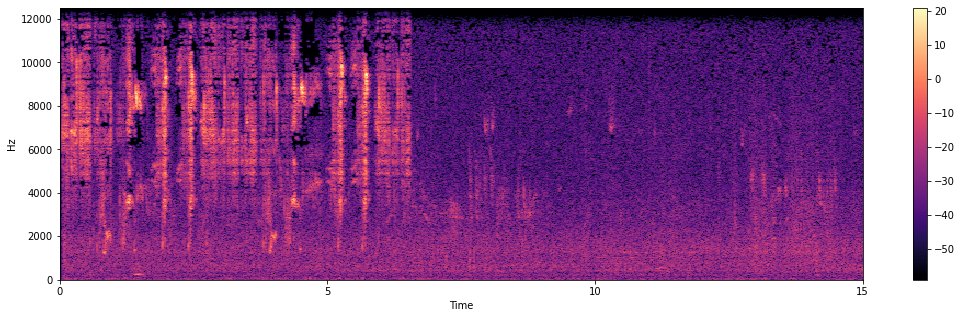

In [5]:
plt.figure(figsize=(18, 5))
X = librosa.stft(data)

# Convert an amplitude spectrogram to dB-scaled spectrogram.
Xdb = librosa.amplitude_to_db(np.abs(X))

#Display a spectrogram/chromagram/cqt/etc.
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')

plt.colorbar()

/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


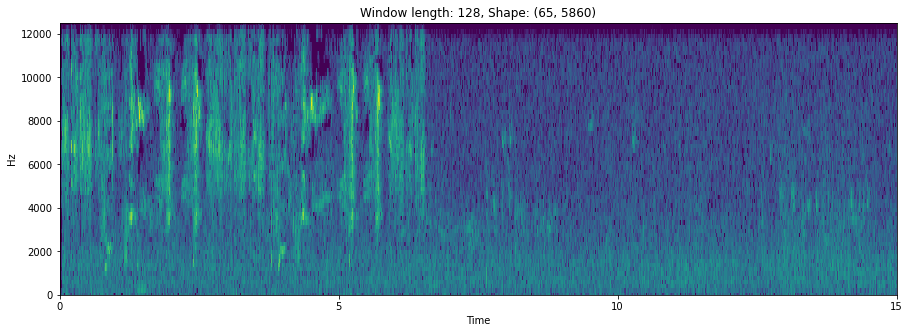

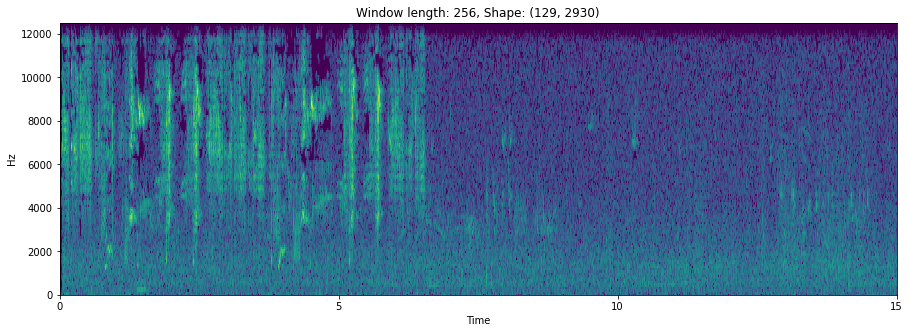

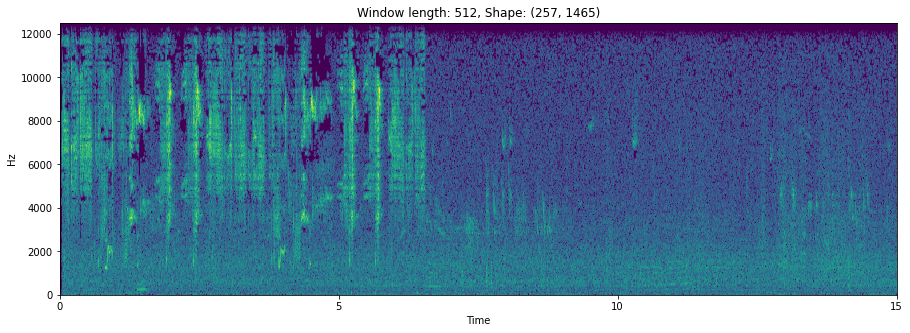

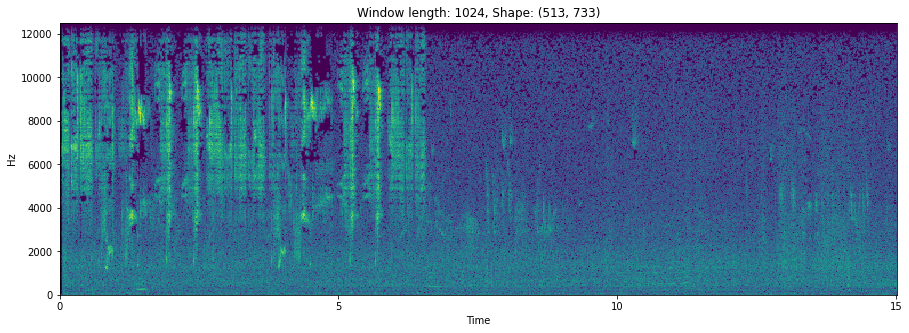

In [6]:
# Try a few window lengths (should be a power of 2)
for win_length in [128, 256, 512, 1024]:
    # data, sample_rate
    # We want 50% overlap between samples
    hop_length = win_length // 2
    
    # Compute spec (win_length implicity also sets n_fft and vice versa)
    spec = librosa.stft(data, 
                        n_fft=win_length, 
                        hop_length=hop_length)
    
    # Scale to decibel scale
    spec_db = librosa.amplitude_to_db(spec, ref=np.max)
    
    # Show plot
    plt.figure(figsize=(15, 5))
    plt.title('Window length: ' + str(win_length) + ', Shape: ' + str(spec_db.shape))
    librosa.display.specshow(spec_db, 
                             sr=SR, 
                             hop_length=hop_length, 
                             x_axis='time', 
                             y_axis='hz', 
                             cmap=plt.get_cmap('viridis'))

# MELSCPECTOGRAM

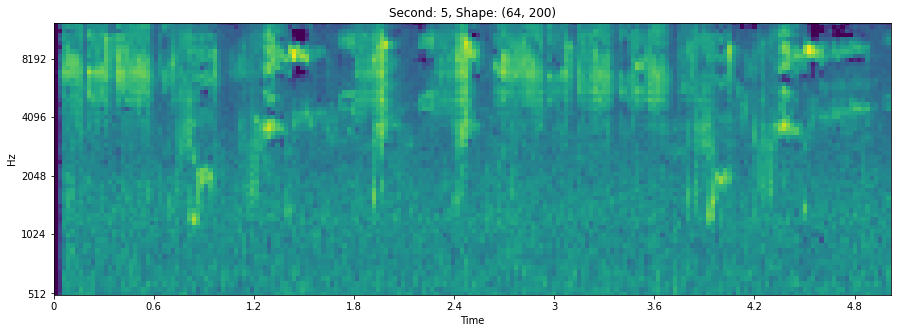

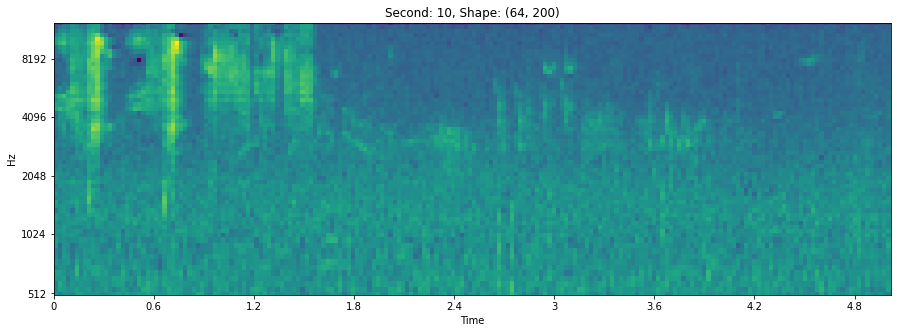

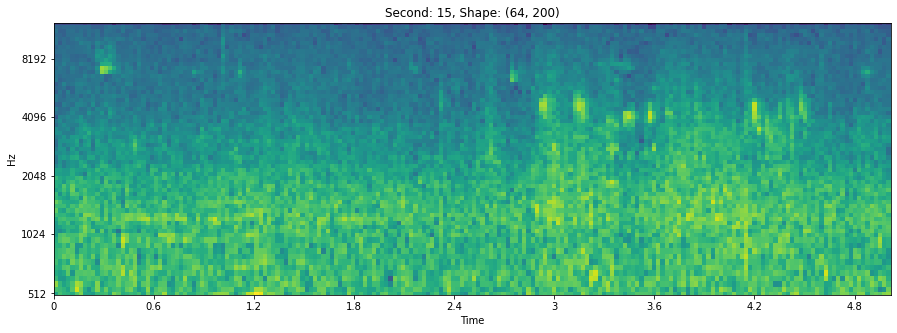

In [7]:
# Desired shape of the input spectrogram
SPEC_HEIGHT = 64
SPEC_WIDTH = 256

# Derive num_mels and hop_length from desired spec shape
# num_mels is easy, that's just spec_height
# hop_length is a bit more complicated
NUM_MELS = SPEC_HEIGHT
HOP_LENGTH = int(32000 * 5 / (SPEC_WIDTH - 1)) # sample rate * duration / spec width - 1 == 627

# High- and low-pass frequencies
# For many birds, these are a good choice
FMIN = 500
FMAX = 12500

# Let's get all three spectrograms
for second in [5, 10, 15]:  
    
    # Get start and stop sample
    s_start = (second - 5) * SR
    s_end = second * SR

    # Compute the spectrogram and apply the mel scale
    mel_spec = librosa.feature.melspectrogram(y=data[s_start:s_end], 
                                              sr=SR, 
                                              n_fft=1024, 
                                              hop_length=HOP_LENGTH, 
                                              n_mels=NUM_MELS, 
                                              fmin=FMIN, 
                                              fmax=FMAX)
    
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Show the spec
    plt.figure(figsize=(15, 5))
    plt.title('Second: ' + str(second) + ', Shape: ' + str(mel_spec_db.shape))
    librosa.display.specshow(mel_spec_db, 
                             sr=SR, 
                             hop_length=HOP_LENGTH, 
                             x_axis='time', 
                             y_axis='mel',
                             fmin=FMIN, 
                             fmax=FMAX, 
                             cmap=plt.get_cmap('viridis'))

### Converting frequency axis into log scale

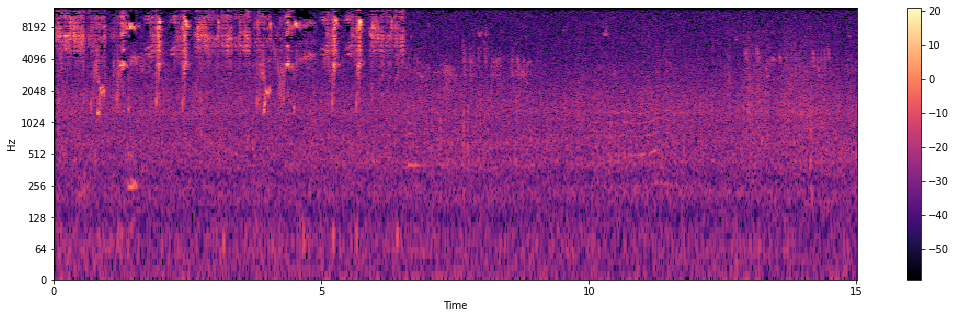

In [8]:
plt.figure(figsize=(18, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar()

# EDA 

In [9]:
path = '../input/birdclef-2021/'
train_metadata = pd.read_csv(path + 'train_metadata.csv',)
train_csv = pd.read_csv(path + "train_soundscape_labels.csv")
test_csv = pd.read_csv(path + "test.csv")
sample_sub= pd.read_csv(path + "sample_submission.csv")

In [10]:
train_metadata.sample(15)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
41771,rebnut,[],['call'],33.253600,-108.801000,Sitta canadensis,Red-breasted Nuthatch,Jarrod Swackhamer,2015-10-05,XC284241.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,09:00,https://www.xeno-canto.org/284241
10810,btnwar,[],['song'],55.571600,-120.718400,Setophaga virens,Black-throated Green Warbler,Jeff Dyck,2018-06-17,XC421770.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,10:00,https://www.xeno-canto.org/421770
1622,amerob,[],['call'],43.719000,-103.480800,Turdus migratorius,American Robin,Jonathon Jongsma,2015-06-23,XC254483.ogg,Creative Commons Attribution-ShareAlike 4.0,5.0,21:00,https://www.xeno-canto.org/254483
53455,thbeup1,[],['song?'],-6.349800,-79.484800,Euphonia laniirostris,Thick-billed Euphonia,Willem-Pier Vellinga,2006-02-13,XC5245.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,9:11,https://www.xeno-canto.org/5245
57525,whbnut,['reevir1'],['song'],42.032300,-79.423700,Sitta carolinensis,White-breasted Nuthatch,Jim Berry,2016-05-21,XC317862.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.5,07:30,https://www.xeno-canto.org/317862
51285,squcuc1,[],['call'],-23.250600,-45.973600,Piaya cayana,Squirrel Cuckoo,Dante Buzzetti,2007-05-18,XC550377.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/550377
9385,botgra,[],"['alarm call', 'call', 'female', 'female and m...",31.946600,-81.022900,Quiscalus major,Boat-tailed Grackle,Russ Wigh,2013-06-08,XC137832.ogg,Creative Commons Attribution-NonCommercial-Sha...,5.0,15:00,https://www.xeno-canto.org/137832
30798,larspa,"['normoc', 'comgra', 'weskin', 'caskin', 'moud...","['call', 'song']",40.640900,-104.339700,Chondestes grammacus,Lark Sparrow,Richard E. Webster,2014-06-04,XC184978.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,05:16,https://www.xeno-canto.org/184978
30285,indbun,"['acafly', 'amerob', 'norcar', 'amered', 'bugg...","['male', 'song']",43.154600,-91.238600,Passerina cyanea,Indigo Bunting,Paul Marvin,2011-05-22,XC192313.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,11:34,https://www.xeno-canto.org/192313
41052,purfin,[],['song'],48.398000,-123.637000,Haemorhous purpureus,Purple Finch,Ian Cruickshank,2010-06-03,XC161662.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,10:30,https://www.xeno-canto.org/161662


In [11]:
print("There are total {} species".format(train_metadata['primary_label'].nunique()))

There are total 397 species


In [12]:
# Utils
def plotbar(series, pal):
    plt.figure(figsize=(20, 9))
    chart = sns.barplot(x=series.index, y=series.values, edgecolor=(0,0,0), linewidth=2, palette=(pal))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

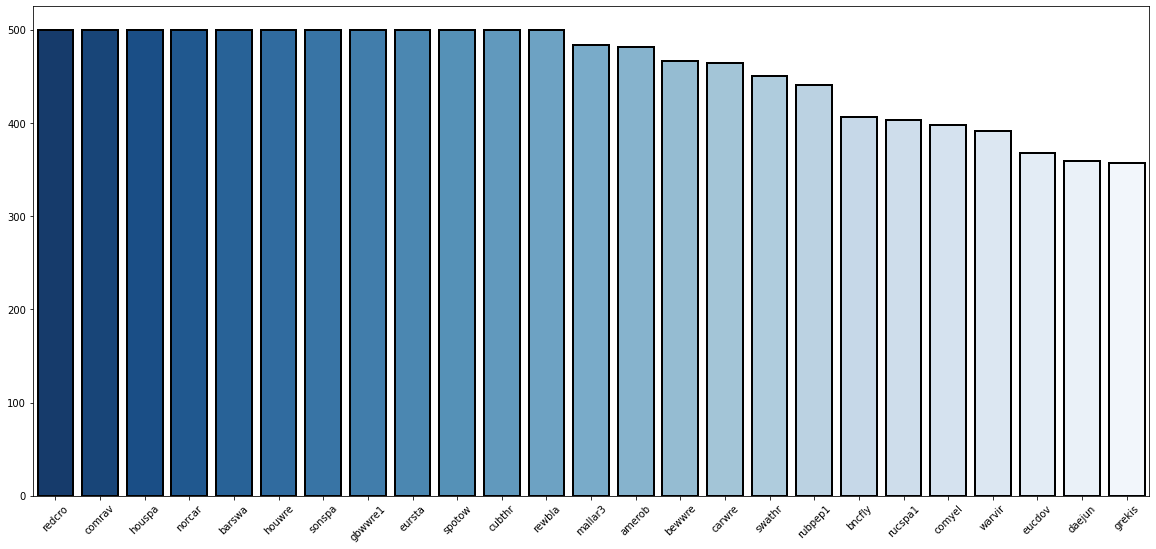

In [13]:
species = train_metadata['primary_label'].value_counts()[:25]
plotbar(species, "Blues_r") # series, palette

<AxesSubplot:xlabel='rating', ylabel='count'>

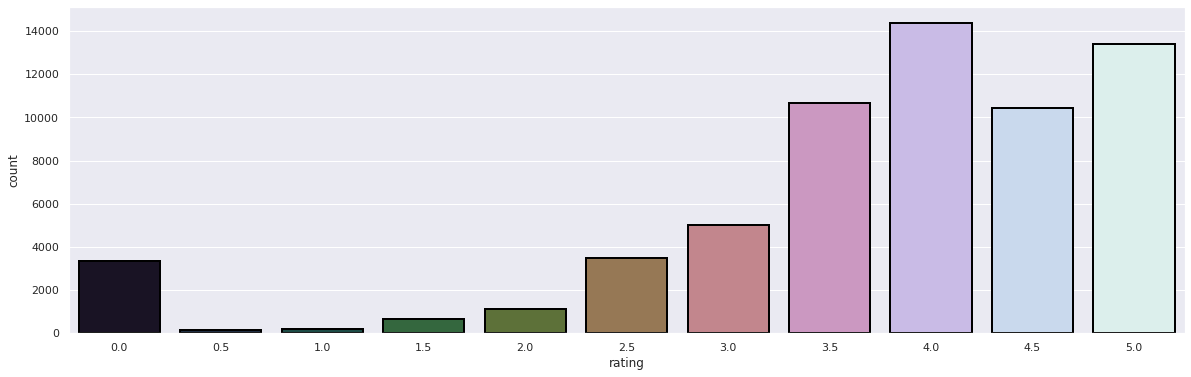

In [14]:
sns.set(rc={'figure.figsize':(20,6)})
sns.countplot(x='rating', data=train_metadata, edgecolor=(0,0,0), linewidth=2, palette=('cubehelix'))

# Type

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Type')

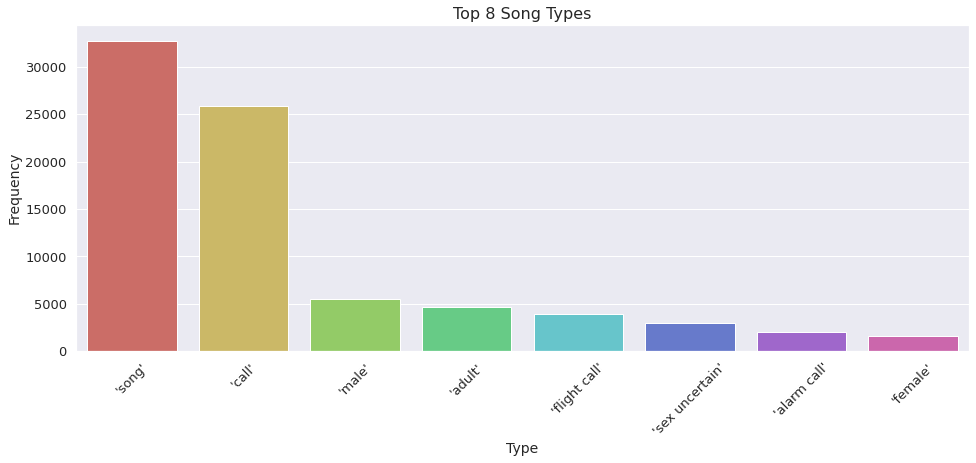

In [15]:
adjusted_type = train_metadata['type'].apply(lambda x: x.replace('[', ''))
adjusted_type = adjusted_type.apply(lambda x: x.replace(']', ''))
adjusted_type = adjusted_type.apply(lambda x: x.split(',')).reset_index().explode("type")
# Strip of white spaces and convert to lower chars
adjusted_type = adjusted_type['type'].apply(lambda x: x.strip().lower()).reset_index()
adjusted_type['type'] = adjusted_type['type'].replace('calls', 'call')
# Create Top 8 list with song types
top_8 = list(adjusted_type['type'].value_counts().head(8).reset_index()['index'])
data = adjusted_type[adjusted_type['type'].isin(top_8)]

plt.figure(figsize=(16, 6))
ax = sns.countplot(data['type'], palette="hls", order = data['type'].value_counts().index)

plt.title("Top 8 Song Types", fontsize=16)
plt.ylabel("Frequency", fontsize = 14)
plt.yticks(fontsize = 13) 
plt.xticks(rotation = 45, fontsize = 13) 
plt.xlabel("Type", fontsize = 14)

## Plot on Map
*References:* [Blog](https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


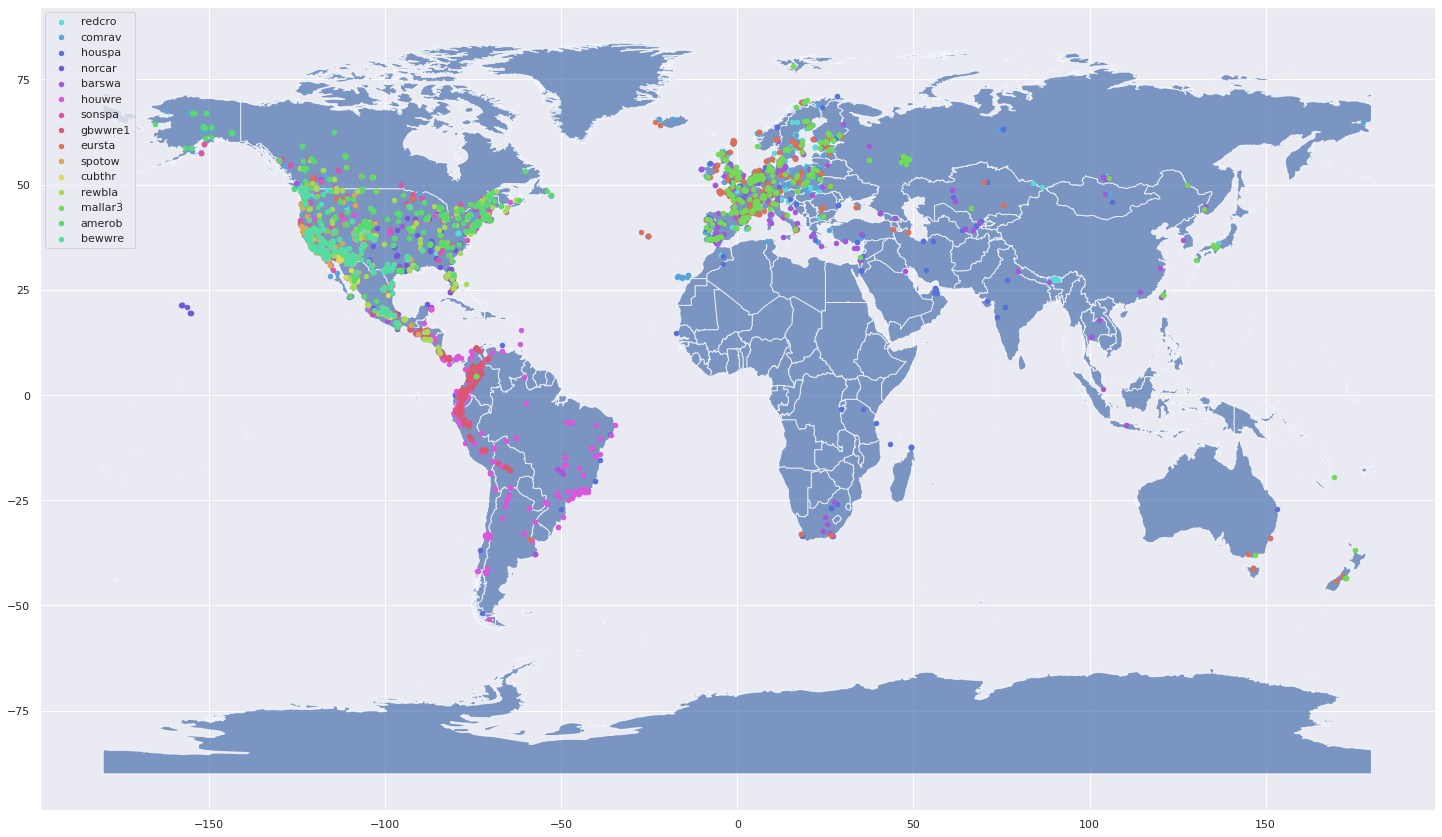

In [16]:
# SHP file
world_map = gpd.read_file("../input/world-countries-shp-file/TM_WORLD_BORDERS-0.3.shp")
crs={'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(train_metadata["longitude"], train_metadata['latitude'])]

geo_df = gpd.GeoDataFrame(train_metadata, crs=crs, geometry=geometry)

# top 15 most species
species_list = species.reset_index()['index'].values[:15]

species_id = geo_df["primary_label"].value_counts().reset_index()
species_id.insert(0, 'ID', range(0, 0 + len(species_id)))

species_id.columns = ["ID", "primary_label", "count"]

# Add ID to geo_df
geo_df = pd.merge(geo_df, species_id, how="left", on="primary_label")


fig, ax = plt.subplots(figsize=(25, 15))
world_map.plot(ax=ax, alpha=0.7)

palette = iter(sns.hls_palette(len(species_list), h=.5))
for i in range(len(species_list)):
    geo_df[geo_df["ID"] == i].plot(ax=ax, 
                                   markersize=20, 
                                   color=next(palette), 
                                   marker="o", 
                                   label = species_id['primary_label'].values[i])
    
ax.legend()
